# **Source: https://www.kaggle.com/code/dariusfoodeei/multiclass-skincancer-torch**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 103.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
columns_rearranged = ['image', 'NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']

skin_cancer_df = pd.read_csv('/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/GroundTruth.csv')
skin_cancer_df.drop(columns=['BKL'], inplace=True)
skin_cancer_df = skin_cancer_df[columns_rearranged]

"""
skin_cancer_2019_df = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
skin_cancer_2019_df.drop(columns=['BKL', 'SCC', 'UNK'], inplace=True)
skin_cancer_2019_df.rename(columns={'AK': 'AKIEC'}, inplace=True)
skin_cancer_2019_df = skin_cancer_2019_df[columns_rearranged]
"""

Using device: cuda


"\nskin_cancer_2019_df = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')\nskin_cancer_2019_df.drop(columns=['BKL', 'SCC', 'UNK'], inplace=True)\nskin_cancer_2019_df.rename(columns={'AK': 'AKIEC'}, inplace=True)\nskin_cancer_2019_df = skin_cancer_2019_df[columns_rearranged]\n"

In [ ]:
multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

filenames_list, multiclass_categories_list = [], []

# base_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images"


base_paths = [
    ("/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images", skin_cancer_df),
]


In [ ]:
for base_path, database in base_paths:
    if isinstance(database, pd.DataFrame):
        for row in database.itertuples(index=False):
            filename = os.path.join(base_path, row[0]) + '.jpg'
            filenames_list.append(filename)
            multiclass_index = np.argmax(row[1:])
            multiclass_categories_list.append(multiclass_index)
    else:
        for sub_directory in database[0]:
            for sub_sub_directory in database[1]:
                final_path = os.path.join(base_path, sub_directory, sub_sub_directory)
                for filename in os.listdir(final_path):
                    filenames_list.append(os.path.join(final_path, filename))
                    if sub_sub_directory in ['nevus', 'NotMelanoma']:
                        multiclass_categories_list.append(0)
                    else:
                        multiclass_categories_list.append(database[1].index(sub_sub_directory))

multiclass_df = pd.DataFrame({"filename": filenames_list, "category": multiclass_categories_list})
multiclass_df = multiclass_df.sample(frac=1).reset_index(drop=True)

multiclass_class_counts = np.bincount(multiclass_categories_list)
multiclass_class_weights = {i: len(multiclass_categories_list) / (2.0 * count) for i, count in enumerate(multiclass_class_counts)}

print(f"Multi-class weights: {multiclass_class_weights}")

Multi-class weights: {0: 0.6416581240389544, 1: 4.499101527403414, 2: 9.742217898832685, 3: 15.313455657492355, 4: 43.54347826086956, 5: 35.264084507042256}


<ipython-input-7-a76bd2b1a029>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)


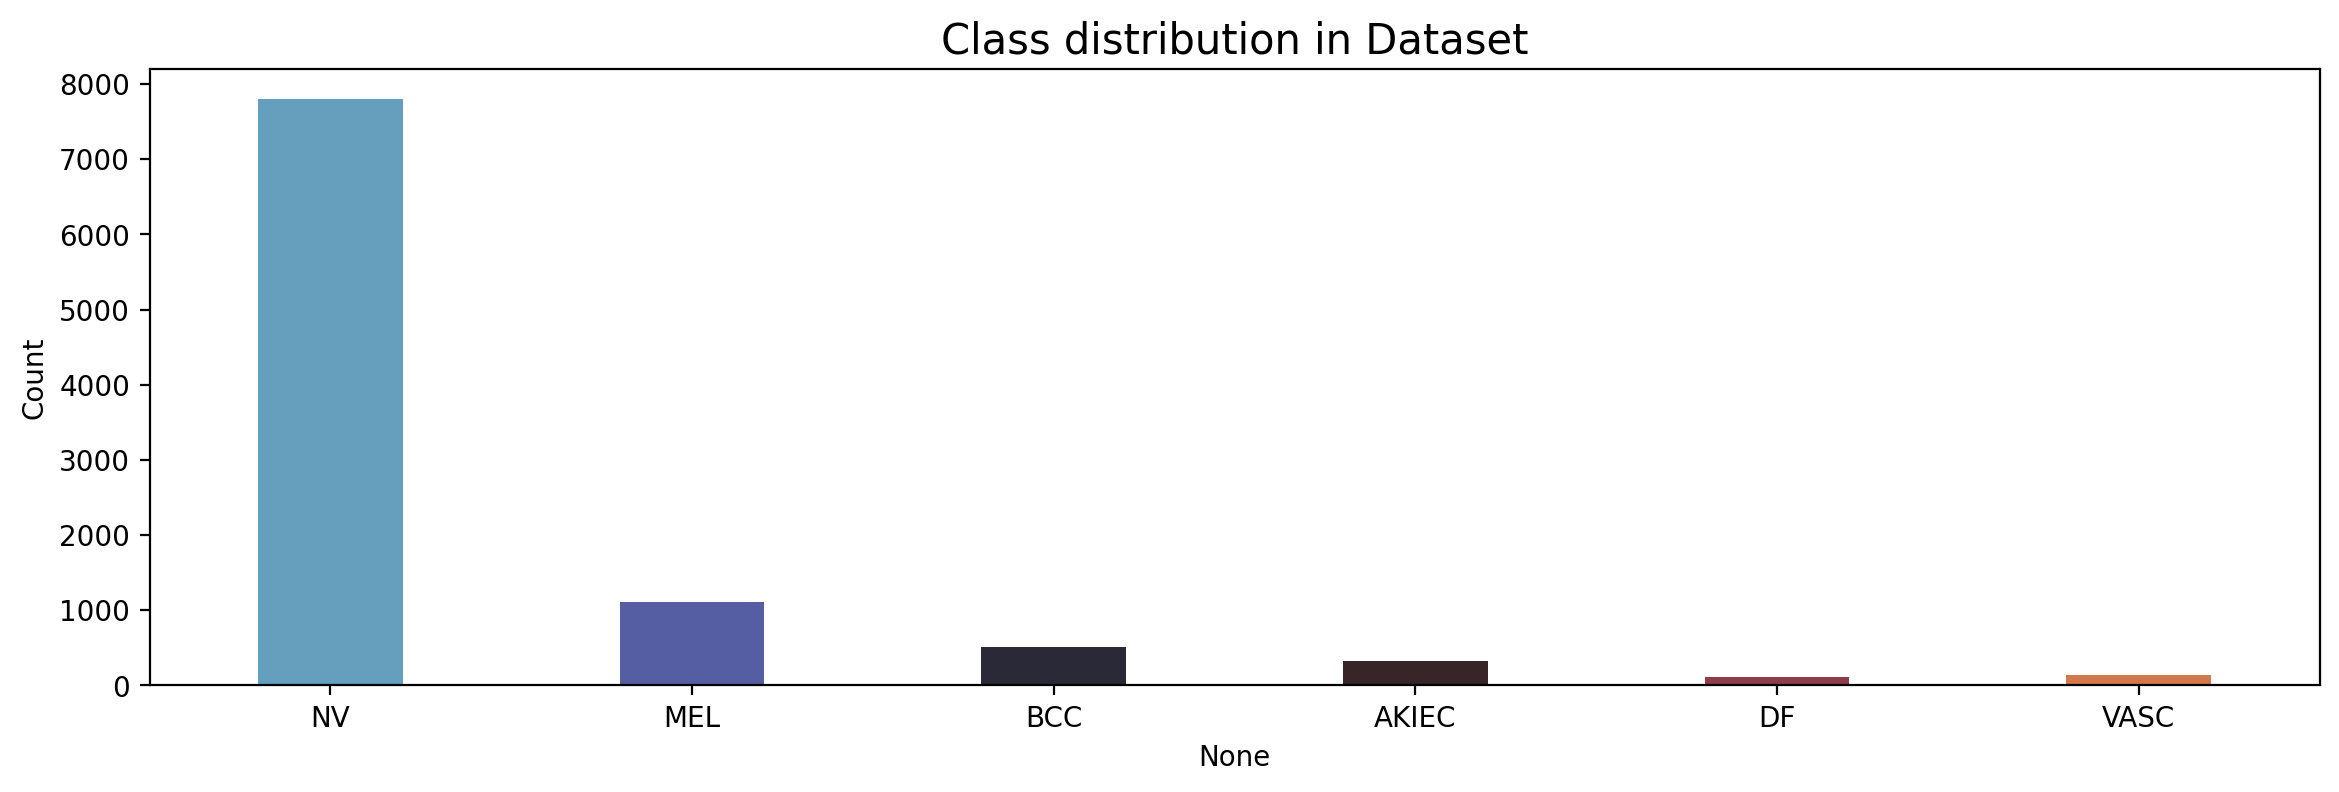

In [ ]:
# Visualization
label, count = np.unique(multiclass_df.category, return_counts=True)
uni = pd.DataFrame(data=count, index=multiclass_categories.values(), columns=['Count'])

plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)
plt.show()

In [ ]:
from PIL import Image
import os

dataset_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images"
valid_images = []

for img_file in os.listdir(dataset_path):
    try:
        img_path = os.path.join(dataset_path, img_file)
        with Image.open(img_path) as img:
            img.verify()  # Verify that the file is intact
        valid_images.append(img_file)
    except Exception as e:
        print(f"Skipping corrupted image: {img_file}, Error: {e}")

Skipping corrupted image: LICENSE.txt, Error: cannot identify image file '/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/LICENSE.txt'
Skipping corrupted image: ATTRIBUTION.txt, Error: cannot identify image file '/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/ATTRIBUTION.txt'


In [ ]:
# Train-validation-test split
multiclass_train_df, multiclass_temp_df = train_test_split(multiclass_df, test_size=0.2, stratify=multiclass_df['category'], random_state=42)
multiclass_cv_df, multiclass_test_df = train_test_split(multiclass_temp_df, test_size=0.5, stratify=multiclass_temp_df['category'], random_state=42)

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

image_size = (224, 224)
batch_size = 32

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SkinCancerDataset(multiclass_train_df, transform=transform)
val_dataset = SkinCancerDataset(multiclass_cv_df, transform=transform)
test_dataset = SkinCancerDataset(multiclass_test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

model = MobileNetV3(num_classes=len(multiclass_categories))
model = model.to(device)

[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 124MB/s]


['Tesla T4']

In [69]:
model = MobileNetV3(num_classes=len(multiclass_categories))
model = model.to(device)

# Define the criterion with class weights
class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

num_epochs = 20
early_stopping_patience = 6
best_val_loss = float('inf')
epochs_no_improve = 0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# This might result in partially loaded images, so proceed with caution !!!!
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)

    return train_loss, train_accuracy

def validate_one_epoch(epoch, model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(epoch, model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate_one_epoch(epoch, model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping")
            break

train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device)

Training Epoch 1/20:   0%|                                                  | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 1/20: 100%|████████████████████████████████████████| 32/32 [00:13<00:00,  2.37it/s]


Epoch 1/20, Train Loss: 1.4835, Train Accuracy: 0.5997, Validation Loss: 1.4092, Validation Accuracy: 0.6154


Validation Epoch 2/20: 100%|████████████████████████████████████████| 32/32 [00:13<00:00,  2.38it/s]


Epoch 2/20, Train Loss: 1.3723, Train Accuracy: 0.6397, Validation Loss: 1.3630, Validation Accuracy: 0.5734


Validation Epoch 3/20: 100%|████████████████████████████████████████| 32/32 [00:13<00:00,  2.36it/s]


Epoch 3/20, Train Loss: 1.3259, Train Accuracy: 0.6732, Validation Loss: 1.3350, Validation Accuracy: 0.7013


Validation Epoch 4/20: 100%|████████████████████████████████████████| 32/32 [00:15<00:00,  2.03it/s]


Epoch 4/20, Train Loss: 1.3287, Train Accuracy: 0.6900, Validation Loss: 1.3442, Validation Accuracy: 0.6464


Validation Epoch 5/20: 100%|████████████████████████████████████████| 32/32 [00:19<00:00,  1.66it/s]


Epoch 5/20, Train Loss: 1.3083, Train Accuracy: 0.6938, Validation Loss: 1.3564, Validation Accuracy: 0.6583


Validation Epoch 6/20: 100%|████████████████████████████████████████| 32/32 [00:17<00:00,  1.80it/s]


Epoch 6/20, Train Loss: 1.2914, Train Accuracy: 0.7106, Validation Loss: 1.3214, Validation Accuracy: 0.7752


Validation Epoch 7/20: 100%|████████████████████████████████████████| 32/32 [00:15<00:00,  2.00it/s]


Epoch 7/20, Train Loss: 1.2839, Train Accuracy: 0.7158, Validation Loss: 1.3352, Validation Accuracy: 0.6274


Validation Epoch 8/20: 100%|████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]


Epoch 8/20, Train Loss: 1.2566, Train Accuracy: 0.7210, Validation Loss: 1.3096, Validation Accuracy: 0.6813


Validation Epoch 9/20: 100%|████████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]


Epoch 9/20, Train Loss: 1.2674, Train Accuracy: 0.7346, Validation Loss: 1.3366, Validation Accuracy: 0.6593


Validation Epoch 10/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.61it/s]


Epoch 10/20, Train Loss: 1.2926, Train Accuracy: 0.7228, Validation Loss: 1.3558, Validation Accuracy: 0.7333


Validation Epoch 11/20: 100%|███████████████████████████████████████| 32/32 [00:21<00:00,  1.46it/s]


Epoch 11/20, Train Loss: 1.2605, Train Accuracy: 0.7069, Validation Loss: 1.2981, Validation Accuracy: 0.7752


Validation Epoch 12/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.67it/s]


Epoch 12/20, Train Loss: 1.2555, Train Accuracy: 0.7329, Validation Loss: 1.3299, Validation Accuracy: 0.7043


Validation Epoch 13/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.67it/s]


Epoch 13/20, Train Loss: 1.2592, Train Accuracy: 0.7294, Validation Loss: 1.3266, Validation Accuracy: 0.6983


Validation Epoch 14/20: 100%|███████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]


Epoch 14/20, Train Loss: 1.2407, Train Accuracy: 0.7408, Validation Loss: 1.2761, Validation Accuracy: 0.7303


Validation Epoch 15/20: 100%|███████████████████████████████████████| 32/32 [00:17<00:00,  1.86it/s]


Epoch 15/20, Train Loss: 1.2481, Train Accuracy: 0.7471, Validation Loss: 1.2500, Validation Accuracy: 0.7283


Validation Epoch 16/20: 100%|███████████████████████████████████████| 32/32 [00:21<00:00,  1.50it/s]


Epoch 16/20, Train Loss: 1.2396, Train Accuracy: 0.7302, Validation Loss: 1.3505, Validation Accuracy: 0.6434


Validation Epoch 17/20: 100%|███████████████████████████████████████| 32/32 [00:16<00:00,  1.89it/s]


Epoch 17/20, Train Loss: 1.2406, Train Accuracy: 0.7509, Validation Loss: 1.3319, Validation Accuracy: 0.7093


Validation Epoch 18/20: 100%|███████████████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]


Epoch 18/20, Train Loss: 1.2316, Train Accuracy: 0.7483, Validation Loss: 1.2785, Validation Accuracy: 0.7552


Validation Epoch 19/20: 100%|███████████████████████████████████████| 32/32 [00:20<00:00,  1.60it/s]


Epoch 19/20, Train Loss: 1.2030, Train Accuracy: 0.7656, Validation Loss: 1.2283, Validation Accuracy: 0.7393


Validation Epoch 20/20: 100%|███████████████████████████████████████| 32/32 [00:19<00:00,  1.68it/s]

Epoch 20/20, Train Loss: 1.1869, Train Accuracy: 0.7752, Validation Loss: 1.2624, Validation Accuracy: 0.7712


In [71]:
# Test the model
model.eval()
test_loss = 0.0
correct_test = 0

# Create a dummy input tensor matching the input dimensions of the model
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')  # Example for a model with 3-channel image input

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx", export_params=True, opset_version=10)

predictions = []
true_classes = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Testing: 100%|██████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s]

Test Loss: 1.2410
Test Accuracy: 75.75%


In [72]:
# Calculate precision
precision = accuracy_score(true_classes, predictions) * 100
print(f'Precision: {precision:.2f}%')

Precision: 75.75%


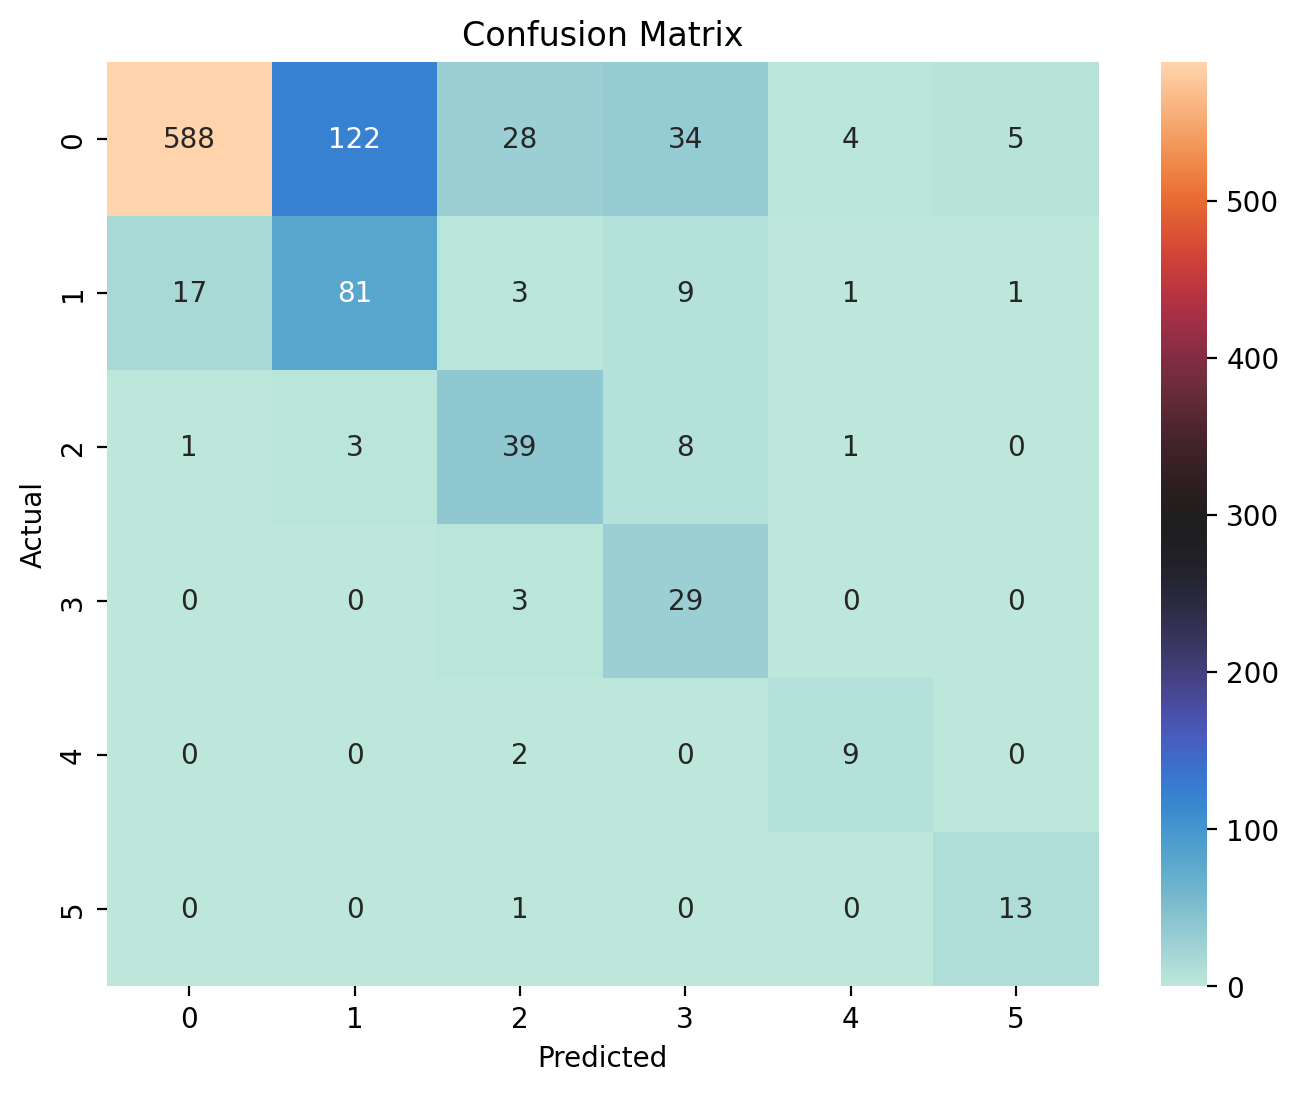

In [73]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=multiclass_categories.keys(), yticklabels=multiclass_categories.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [74]:
# Save the model
torch.save(model.state_dict(), 'multiclass_model_final.pth')

# Load an image-label pair from the test dataset
image, label = test_dataset.__getitem__(0)
print(image)

# Ensure the model is in evaluation mode
model.eval()

# If you're using a GPU, you also need to send the image and the model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)  # Send the image to the GPU if you're using one

# Perform the forward pass with no_grad to save memory and compute speed
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add a batch dimension

# Print the output
print("output: ", output)

# To get the predicted class
predicted_class = torch.argmax(output)
print(f"Predicted class: {predicted_class}")

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# **XAI Approaches**

In [75]:
# Inspect the model architecture
print(model)

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

In [ ]:
# GRAD-CAM
import cv2
from torchvision.transforms.functional import normalize

"""
def get_grad_cam(model, image, target_class, layer_name='features.0'):

    # Generate a Grad-CAM heatmap for a single image.

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    layer = dict([*model.named_modules()])[layer_name]
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    # Forward pass
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    output = model(image)

    # Backward pass for the target class
    model.zero_grad()
    target = torch.tensor([target_class]).to(device)
    loss = criterion(output, target)
    loss.backward()

    # Generate Grad-CAM heatmap
    grads = gradients[0].squeeze(0).cpu().numpy()
    activs = activations[0].squeeze(0).detach().cpu().numpy()
    weights = grads.mean(axis=(1, 2))  # Global average pooling

    cam = np.zeros(activs.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activs[i]

    # Normalize and resize the heatmap
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / cam.max() if cam.max() != 0 else cam
    cam = cv2.resize(cam, (224, 224))
    return cam
"""

def get_grad_cam(model, image, target_class, layer_name):
    if isinstance(layer_name, int):  # If layer_name is an integer index
        target_layer = model.model.features[layer_name]
    else:  # If layer_name is a string
        target_layer = dict(model.named_modules())[layer_name]

    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    # Register hooks
    forward_hook_handle = target_layer.register_forward_hook(forward_hook)
    backward_hook_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.zero_grad()
    output = model(image.unsqueeze(0))  # Add batch dimension
    class_score = output[0, target_class]
    class_score.backward()

    # Clean up hooks
    forward_hook_handle.remove()
    backward_hook_handle.remove()

    return activations['value'], gradients['value']


def visualize_grad_cam(image, cam, alpha=0.5):
    """
    Overlay the Grad-CAM heatmap on the original image.
    """
    # Convert the CAM to a heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Convert the image to uint8 and scale to 0-255 if necessary
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
        image = np.uint8(255 * image)  # Scale to [0, 255]

    # Ensure both heatmap and image have the same shape and dtype
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to match image size

    # Blend the image and heatmap
    superimposed_image = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_image

# Test Grad-CAM
# Determine the layer name
layer_name = 12  # Select the 12th layer in `features`
image = image.to(device)
activations, gradients = get_grad_cam(model, image, target_class=label, layer_name=layer_name)

# Generate CAM
weights = gradients.mean(dim=(2, 3), keepdim=True)
cam = (weights * activations).sum(dim=1).squeeze()  # Compute weighted sum across channels.
# cam = torch.clamp(cam, min=0)  # Apply ReLU to focus on positive influence.

# Normalize the CAM to range [0, 1]
cam = cam - cam.min()
cam = cam / cam.max()

# Convert the image tensor to NumPy (H, W, C) and normalize it
image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0, 1]

# Ensure cam is a NumPy array
cam = cam.detach().cpu().numpy()  # Detach and move to CPU

# Visualize the Grad-CAM
superimposed_image = visualize_grad_cam(image_np, cam)
plt.imshow(superimposed_image)
plt.title(f'Grad-CAM for Class {label}')
plt.axis('off')
plt.show()


"""
# Visualize
plt.imshow(visualize_grad_cam(transforms.ToPILImage()(image.cpu()), cam.detach().cpu().numpy()))
plt.title(f'Grad-CAM for Class {label}')
plt.axis('off')
plt.show()
"""


error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:683: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'arithm_op'


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b2aa60dcefada0e9ae37d682d90d99fc9a0eb40025614acc0106c33882023619
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

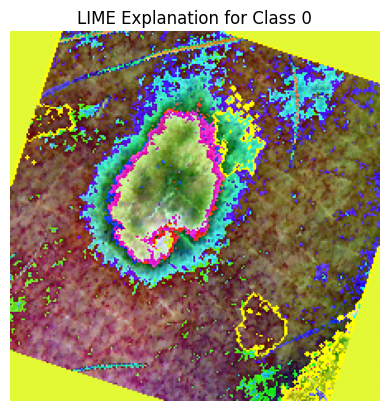

In [76]:
# LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(0)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Visualize explanation
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation for Class {label}')
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

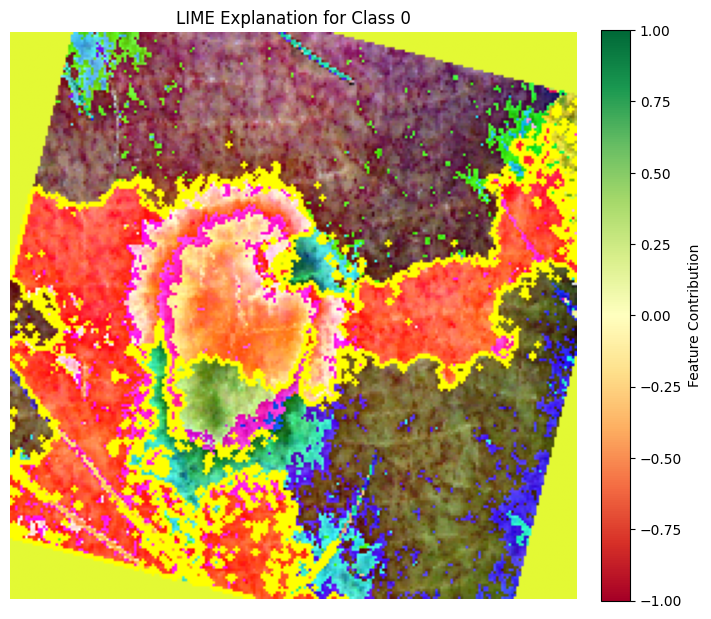

In [77]:
# LIME WITH LEGEND
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(0)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=False,  # Only show positive contributions
    num_features=5,  # Number of features (segments) to show
    hide_rest=False
)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation for Class {label}')
ax.axis('off')

# Create a colorbar to show positive and negative contributions
import matplotlib as mpl
cmap = mpl.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive
norm = mpl.colors.Normalize(vmin=-1, vmax=1)  # Normalize the color scale

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

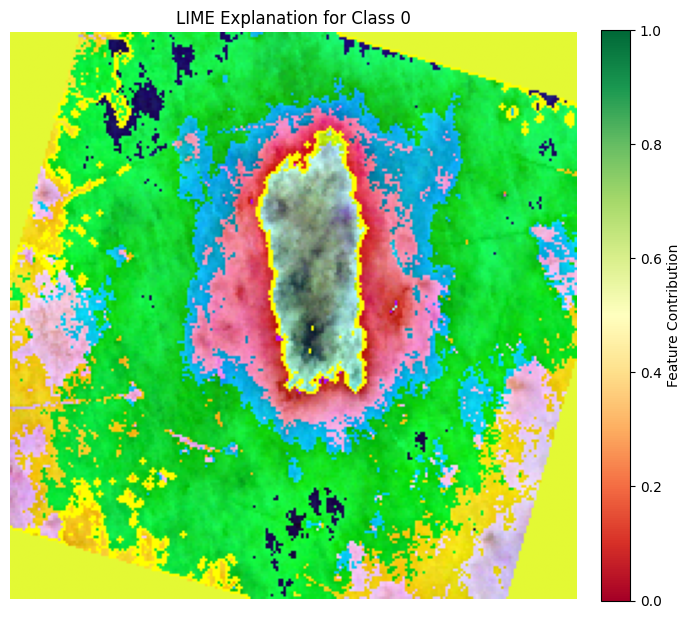

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib as mpl

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(123)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=5,  # Number of features (segments) to show
    hide_rest=False
)

# Clip the mask to ensure it is within the expected range [0, 1] before applying the colormap
# mask = np.clip(mask, 0, 1)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation for Class {label}')
ax.axis('off')

# Create a colorbar to show positive and negative contributions
cmap = mpl.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive
# norm = mpl.colors.Normalize(vmin=0, vmax=1)  # Normalize the color scale to [0, 1]

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

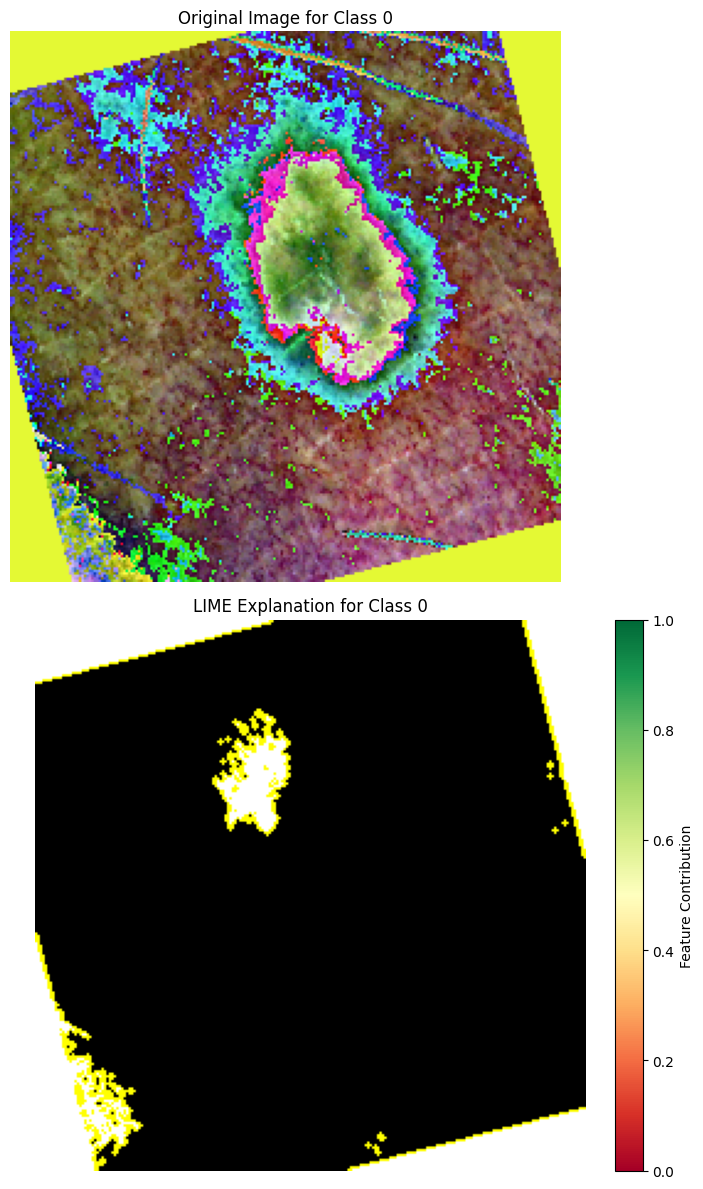

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib as mpl

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
    images = images.to(device)
    outputs = model(images)
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(0)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=5,  # Number of features (segments) to show
    hide_rest=True
)

# Create a subplot with two rows: one for the original image and one for the LIME explanation
fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # 2 rows, 1 column

# Show the original image at the top (axes[0])
axes[0].imshow(image_np)
axes[0].set_title(f'Original Image for Class {label}')
axes[0].axis('off')

# Show the LIME explanation at the bottom (axes[1])
axes[1].imshow(mark_boundaries(temp, mask))  # Overlay boundaries on the explanation
axes[1].set_title(f'LIME Explanation for Class {label}')
axes[1].axis('off')

# Create a colorbar for the LIME explanation
cmap = mpl.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive

# Add colorbar for the LIME explanation on the right
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import shap
import torch
from torchvision import transforms
from PIL import Image

# Initialize SHAP explainer
def shap_explainer(model, background_data, transform, device):
    def model_forward(x):
        # Apply the transform to the images
        x_tensor = torch.stack([transform(img).to(device) for img in x])  # Ensure images are in the correct format
        return model(x_tensor).detach().cpu().numpy()

    # Convert background data to tensors
    background_data_tensor = torch.stack([transform(img).to(device) for img in background_data])

    # Create SHAP explainer with the model and transformed background data
    explainer = shap.GradientExplainer(model_forward, background_data_tensor)
    return explainer

# Select background data (images) from your dataset
background_images = [multiclass_train_df.iloc[i, 0] for i in range(5)]
background_images = [Image.open(img_path).convert('RGB') for img_path in background_images]

# Ensure the model is an actual PyTorch model instance (not a function)
# Example:
# model = YourModel()

# Generate SHAP values for a single image
explainer = shap_explainer(model, background_images, transform, device)

# Retrieve an image from the test dataset
image, label = test_dataset.__getitem__(0)

# Compute SHAP values for the image
shap_values = explainer.shap_values(torch.stack([image]).to(device))  # Ensure image is on the correct device

# Visualize SHAP values
shap.image_plot([shap_values], transforms.ToPILImage()(image).numpy())

ValueError: <class 'function'> is not currently a supported model type!